In [34]:
import pandas as pd
import numpy as np
from IPython.display import display

In [3]:
from sqlalchemy import create_engine, Table, MetaData
from sqlalchemy.orm import sessionmaker

In [5]:
db_name = "ethprice"
db_host = "localhost"
db_username = "root"
db_password = "Coolio.io9A"


engine = create_engine(f"mysql+pymysql://{db_username}:{db_password}@{db_host}/{db_name}")
Session = sessionmaker(bind=engine)
session = Session()

In [8]:
eth_stock = pd.read_csv("/Users/aaminathasneemkhaleel/Downloads/ETH-USD.csv")

In [9]:
eth_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,8.932500e+08
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09


In [25]:
print(eth_stock .isnull().sum())
#there is a null value for each which could potentially impact results
null_rows = eth_stock[eth_stock.isnull().any(axis=1)]
print(null_rows)
eth_stock=eth_stock.dropna()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64
            Date  Open  High  Low  Close  Adj Close  Volume
2663  2025-02-23   NaN   NaN  NaN    NaN        NaN     NaN


In [26]:
# after dropping null value
print(eth_stock .isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [27]:
# preliminary analysis stage 1 --> compute summary statistics
summary_stats = {
    "Mean Open": np.mean(eth_stock["Open"]),
    "Median Open": np.median(eth_stock["Open"]),
    "Std. Deviation Open": np.std(eth_stock["Open"]),
    
     "Mean High": np.mean(eth_stock["High"]),
    "Median High": np.median(eth_stock["High"]),
    "Std. Deviation High": np.std(eth_stock["High"]),
    
     "Mean Low": np.mean(eth_stock["Low"]),
    "Median Low": np.median(eth_stock["Low"]),
    "Std. Deviation Low": np.std(eth_stock["Low"]),
    
     "Mean Close": np.mean(eth_stock["Close"]),
    "Median Close": np.median(eth_stock["Close"]),
    "Std. Deviation Close": np.std(eth_stock["Close"]),
    
    "Average Volume": np.mean(eth_stock["Volume"]),
    "Highest Closing Price": np.max(eth_stock["Close"]),
    "Lowest Closing Price": np.min(eth_stock["Close"])
}

summary_df = pd.DataFrame(summary_stats, index=[0])

print(summary_df)

     Mean Open  Median Open  Std. Deviation Open    Mean High  Median High  \
0  1522.818337  1465.419311          1235.287101  1564.434018  1542.162842   

   Std. Deviation High     Mean Low   Median Low  Std. Deviation Low  \
0          1268.019253  1477.121089  1423.441834         1198.562736   

    Mean Close  Median Close  Std. Deviation Close  Average Volume  \
0  1523.560701    1470.71759           1235.022177    1.328927e+10   

   Highest Closing Price  Lowest Closing Price  
0            4812.087402             84.308296  


In [40]:
#volatility analysis
eth_stock["Volatility_7d"] = eth_stock["Close"].rolling(window=7).std()
eth_stock["Volatility_30d"] = eth_stock["Close"].rolling(window=30).std()


 # Defined a threshold (trying to identify periods of high volatility) --> compare this to the blockchain transaction data
volatility_threshold = eth_stock["Volatility_30d"].mean() 
high_volatility_periods = eth_stock[eth_stock["Volatility_30d"] > volatility_threshold]

print(high_volatility_periods["Date"])

40      2017-12-19
41      2017-12-20
42      2017-12-21
43      2017-12-22
44      2017-12-23
           ...    
2659    2025-02-19
2660    2025-02-20
2661    2025-02-21
2662    2025-02-22
2664    2025-02-24
Name: Date, Length: 1080, dtype: object


In [42]:
# moving average and then will conduct an analysis based on the moviong averages for PoW and PoS
#simple moving average and exponential moving average (for both 7 and 30 days)
eth_stock["SMA_7"] = eth_stock["Close"].rolling(window=7).mean()  
eth_stock["SMA_30"] = eth_stock["Close"].rolling(window=30).mean()

#note to self --> When adjust=False, the exponentially weighted function is calculated recursively

eth_stock["EMA_7"] = eth_stock["Close"].ewm(span=7, adjust=False).mean()
eth_stock["EMA_30"] = eth_stock["Close"].ewm(span=30, adjust=False).mean()



In [49]:
#average trading volume
average_volume = eth_stock["Volume"].mean()
print(f"Average Trading Volume: {average_volume}")

#high trading volume days
high_volume_days = eth_stock[eth_stock["Volume"] > 1.5 * eth_stock["Volume"].mean()]
print(high_volume_days["Date"])


Average Trading Volume: 13289272647.650526
825     2020-02-12
826     2020-02-13
827     2020-02-14
828     2020-02-15
829     2020-02-16
           ...    
2652    2025-02-12
2657    2025-02-17
2658    2025-02-18
2661    2025-02-21
2664    2025-02-24
Name: Date, Length: 531, dtype: object


(2664,)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

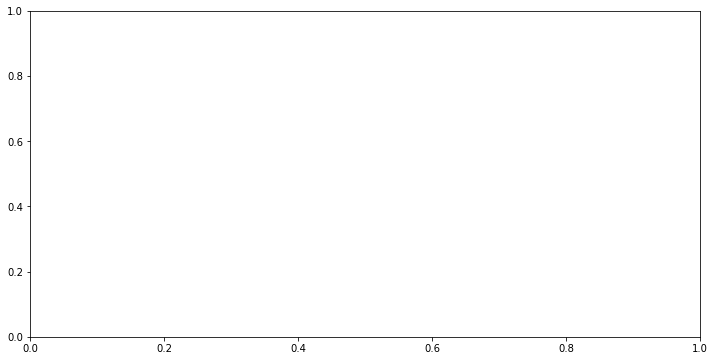

In [56]:
import matplotlib.pyplot as plt

eth_stock["Date"] = pd.to_datetime(eth_stock["Date"])
print(eth_stock["Date"].shape)


plt.figure(figsize=(12,6))
plt.plot(eth_stock["Date"], eth_stock["Close"], label="Closing Price", color="blue")
plt.plot(eth_stock["Date"], eth_stock["SMA_30"], label="30-day SMA", color="red")
plt.plot(eth_stock["Date"], eth_stock["EMA_30"], label="30-day EMA", color="green")
plt.xlabel("Date")
plt.ylabel("Price")

plt.xticks(rotation=45)
plt.legend()
plt.title("ETH Price with Moving Averages")
plt.show()

In [30]:
# block chain data
block = pd.read_json("/Users/aaminathasneemkhaleel/Downloads/latest1K.json")
block.head()

,baseFeePerGas,difficulty,extraData,gasLimit,gasUsed,hash,logsBloom,miner,mixHash,nonce,...,sha3Uncles,size,stateRoot,timestamp,totalDifficulty,transactions,transactionsRoot,uncles,withdrawals,withdrawalsRoot
0,28250398000,0,0x406275696c64657230783639,30000000,10739924,0x7ccc3f05195b26f5c6810318057f49bffc131c2f296e...,0x1461605a494996481088082c911b402440214449ec80...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0x79d73eb8509f6c8b7f1b357fd342aa645666eeea7330...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,47293,0xa8e46aec3d0a50f69dbc2fb379b8176c59548fcddb60...,2023-05-21 02:58:35,5.875000e+22,[0x34efadbef9d09d3863caf60318922fe017d2b385c7a...,0x1720e999daeba3ae712f5782849ee16c8d6c43f36858...,[],"[{'index': '0x41ee2a', 'validatorIndex': '0x9b...",0xeacaa236f198b9a023e820c6626a6557bb5ab2de7e28...
1,27247490980,0,0x506f776572656420627920626c6f58726f757465,30000000,11533407,0xb261647b8b4f80841a578960080f34f5e79eb4173c33...,0x14b17443458215c81528b1f48a0c2420582ec5540a33...,0xf17d119effa0dcbe24d3fa346860be851150358f,0xa51c391172a60e5bb2344fdd413acd430fac6446ea72...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,158324,0x42208030c10c6d5dc13a90b6e3a19be3cacbe35a8ac6...,2023-05-21 02:58:47,5.875000e+22,[0xd14039be8a2f8c5146f231dbab8ff4665962b77f823...,0x055475da4288a7998776840a7761c07e015c3894e97c...,[],"[{'index': '0x41ee3a', 'validatorIndex': '0x9b...",0x848737a067209f01e194775e4cce68320794b43f3b84...
2,26460357968,0,0x7273796e632d6275696c6465722e78797a,30000000,10799859,0xdb70940f8b88d0ef7d7dc738476d9ed056bda2a09261...,0xc4630842510084ed5e082224f1504221512024120e91...,0x1f9090aae28b8a3dceadf281b0f12828e676c326,0xd87039c64393f58641e113883b9daa74713fed16ae5a...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,75547,0x8b37e1f779398ad391ab72aed50e74671939f4b01226...,2023-05-21 02:58:59,5.875000e+22,[0x45ace2431c66a08f7c66d4365a15463618685da4601...,0xd90b68fa3b513f84aab00b1c5dd36fbd0af15ba62e72...,[],"[{'index': '0x41ee4a', 'validatorIndex': '0x9b...",0x59efe39a3d25c592997450d70a42c6c00004e94a2c33...
3,25534214349,0,0x406275696c64657230783639,30000000,16701598,0x90171b4f643920bb9843555793254b62e1f154b22257...,0x132558d5cf769079d56e342c8a063ea1d7f501086414...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0xe91777d1f5927e18e1c8117d85909fb7462af82007b0...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,68591,0xe8e0b2da89b3ad5a97dc027559c2a2569d695d9027f5...,2023-05-21 02:59:11,5.875000e+22,[0x6911109d64313afe782307b0d7e891000cf915ca209...,0x00af854f94c4a305ca9e2b9bc76bdc81cbac40c7ce16...,[],"[{'index': '0x41ee5a', 'validatorIndex': '0x9b...",0xf656e985a21358e644c72585d5606a60a12886f2ba75...
4,25896289082,0,0x496c6c756d696e61746520446d6f63726174697a6520...,30000000,13822589,0xef69c322fc2e149d26aa6f1dbc9fd0401aa681b6202a...,0x0ca108534b84458458685bf7c41425a048875c426ca4...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x6d51b333b142d8ba429ea037965606f36919de22ba79...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,59176,0xaac4782733c30ef11313e4630ab1b0e4e873950f9612...,2023-05-21 02:59:23,5.875000e+22,[0x148af8ff5beae7563b74d9d7f082cbb791f9abc83d1...,0xf3bddb69cfac0c19226404453fd797d0fffbfa559ae2...,[],"[{'index': '0x41ee6a', 'validatorIndex': '0x9b...",0x1851993d099c5fd4bc46904363bd277864de11b7ad3a...
